In [1]:
#import os
#import ipdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error

class RBFNeuralNetwork:
    '''simple feedforward neural network class'''       
    def __init__(self,num_inputs,num_outputs,num_neurons,tf_functions,epochs=100,learning_rate=0.1, mode = 'sequential'):
        self.mode = mode
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_neurons = num_neurons

        self.min_weight_value = -1
        self.max_weight_value = 1
        self.tf_functions = []
        #self.tf_functions_derivatives = []

        for i in range(0,len(tf_functions)):
            if tf_functions[i] == "gaussian":
                self.tf_functions.append(self.tf_gaussian)
                #self.tf_functions_derivatives.append(self.tf_logistic_derivative)                
            elif tf_functions[i] == "linear":
                self.tf_functions.append(self.tf_linear)
                #self.tf_functions_derivatives.append(self.tf_linear_derivative)
            else:
                print("Unknown transfer function: %s" %(tf_function[i]))
                exit()
        self.outputs = None # will be updated after calculation is called

        #********************************
        # Initialize weights and bias
        #********************************
        centers_per_layer = []
        weights_per_layer = []
        biases_per_layer = []
        wsums_per_layer = []  # for helping later activation function approximate derivative calculation
        
        for l in range(0,len(num_neurons)):
            previous_layer_is_input = 0
            if (l == 0):
                previous_layer_size = len(inputs[0])
                previous_layer_is_input = 1
            else:
                previous_layer_size = num_neurons[l-1]
            
            layer_size = num_neurons[l]
            
            if (not previous_layer_is_input):
                layer_weights = np.zeros((layer_size,previous_layer_size))
                layer_biases = np.zeros(layer_size)
            else:
                layer_weights = np.zeros((layer_size,0))
                layer_biases = np.zeros((0))
                layer_centers = np.zeros((layer_size, previous_layer_size))
                
                self.centers_per_layer = layer_centers
                
            weights_per_layer.append(layer_weights)
            biases_per_layer.append(layer_biases)
            wsums_per_layer.append(np.zeros(layer_size))

        self.weights_per_layer = weights_per_layer
        self.biases_per_layer = biases_per_layer    
        self.wsums_per_layer = wsums_per_layer

        self.randomize_weights()
        self.randomize_biases()
        self.randomize_centers()


    def set_last_layer_weights(self,weights):
        self.weights_per_layer[-1] = [weights]
        
    def set_centers(self, centers):
        self.centers_per_layer = centers

    def randomize_weights(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.weights_per_layer):
            #self.weights_per_layer[i] = np.random.random(self.weights_per_layer[i].shape)
            self.weights_per_layer[i] = a+(b-a)*np.random.random(self.weights_per_layer[i].shape)

    def randomize_biases(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.biases_per_layer):
            #self.biases_per_layer[i] = a+(b-a)*np.random.random(self.biases_per_layer[i].shape)
            self.biases_per_layer[i] = self.biases_per_layer[i]*0
            
    def randomize_centers(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.centers_per_layer):
            self.centers_per_layer[i] = a+(b-a)*np.random.random(self.centers_per_layer[i].shape)

    def predict(self,X):
        Ypredicted = []
        for i in range(0,X.shape[0]):  #for every pattern 
            predicted = model.calc_output(X[i]) # calculating outputs for a given pattern
            Ypredicted.append(predicted)
        return np.array(Ypredicted)

    def calc_output(self,inputs):
        '''calculates the output of the neural network'''
        #*****************
        # creates empty output array
        #*****************
        outputs = []
        for i in range(0,len(self.num_neurons)):
            outputs.append(np.zeros(num_neurons[i])) 

        outputs = np.array(outputs) #convert to numpy array
        #*****************
        # calculates output for each layer
        #*****************
        for i in range(0,len(self.num_neurons)):
            if (i == 0): # first layer
                outputs[i] = self.calc_layer_rbf(inputs,self.weights_per_layer[i],self.biases_per_layer[i],self.centers_per_layer,self.tf_functions[i],i)
                #outputs[i] = self.calc_layer(inputs,self.weights_per_layer[i],self.biases_per_layer[i],self.tf_functions[i],i)
            else:
                outputs[i] = self.calc_layer(outputs[i-1],self.weights_per_layer[i],self.biases_per_layer[i],self.tf_functions[i],i)
        self.outputs = outputs
        
        return outputs[-1]

    def calc_layer_rbf(self,inputs,weights,biases,centers,tf_function,layer_index):
        outputs = np.zeros(len(weights))
        for i in range(0,len(weights)): #for all neurons
            outputs[i] = self.neuron_rbf(centers[i],inputs,tf_function,layer_index,i)
        return outputs
    
    
    def calc_layer(self,inputs,weights,biases,tf_function,layer_index):
        outputs = np.zeros(len(weights))
        for i in range(0,len(weights)): #for all neurons
            outputs[i] = self.neuron(weights[i],biases[i],inputs,tf_function,layer_index,i)
        return outputs

    def tf_gaussian(self, x, sigma):
        return np.exp(-((x)/sigma)**2)
    
    def tf_logistic(self,x):
        return 1/(1+np.exp(-x*2))
        #return 1/(1+np.exp(-x))

    def tf_logistic_derivative(self,y):        
        return (1-y)*(y) 

    def tf_linear(self,x):
        return x
    def tf_linear_derivative(self,y):
        return 1

    def neuron(self,weights,bias,inputs,tf_function,layer_index,neuron_index):
        weighted_sum = np.dot(weights,inputs)+bias
        output = tf_function(weighted_sum)

        # update for later calculate activation function approximate derivative
        self.wsums_per_layer[layer_index][neuron_index] = weighted_sum

        return output
    
    def neuron_rbf(self,centers,inputs,tf_function,layer_index,neuron_index):
        summing_section = inputs - centers
        norm_section = np.linalg.norm(summing_section, ord=2)
        output = tf_function(norm_section, sigma = 1)

        # update for later calculate activation function approximate derivative
        self.wsums_per_layer[layer_index][neuron_index] = norm_section

        return output
    
    
    def fit(self,X,Y):

        # sequential approach
        self.ssr_total_list = []
        self.mse_total_list = []
        for epc in range(0,self.epochs+1):
            ssr_total = 0
            mse_total = 0
            idxlist = np.arange(0,X.shape[0])
            #on first evaluation, local gradients are not updated, just to save the initial solution            
            np.random.shuffle(idxlist)  #randomize index_list            
            for i in range(0,X.shape[0]):  
                predicted = model.calc_output(X[idxlist[i]]) # calculating outputs for a given pattern  
                output_error = Y[idxlist[i]] - predicted  # error for each output
                ssr = 0.5*sum(output_error**2) #sum of squared residuals
                ssr_total += ssr
                mse_total += sum(output_error**2)
                # calculate local gradients
                if (epc != 0):
                    self.calculate_local_gradients(output_error,ssr)
                    self.update_weights(X[idxlist[i]])
            mse = mse_total/X.shape[0]
            self.ssr_total_list.append(ssr_total)
            self.mse_total_list.append(mse)
            #print("Epoch: %d \t SSR_total = %f" %(epc,ssr_total))



    def calculate_local_gradients(self,output_error,ssr):
        ''' calculates local gradients '''
        # initializes local gradients
        self.local_gradients = [0]*len(num_neurons) # will be a list for each element
        for i in range(0,len(self.local_gradients)):
            self.local_gradients[i] = np.zeros(num_neurons[i])

        # calculates local gradients for output layer
        for j in range(0,self.num_neurons[-1]): # for all neurons in the output layer
            partiald_E_y = -(output_error[j])
            #local_gradient = -partiald_E_y * self.tf_functions_derivatives[-1](self.outputs[-1][j])
            tf = self.tf_functions[-1]
            local_gradient = -partiald_E_y * self.num_derivative(tf,self.wsums_per_layer[-1][j])
            self.local_gradients[-1][j] = local_gradient

        # calculates local gradients for hidden layers
        for l in range(len(num_neurons)-2,-1,-1):  # for all hidden layers, from last to first
            for j in range(0,num_neurons[l]):
                outsum = 0
                w_from_this_neuron_to_next_layer = self.weights_per_layer[l+1][:,j]
                for o in range(0,num_neurons[l+1]): # for all neurons on the next layer
                    wok = w_from_this_neuron_to_next_layer[o]
                    outsum+= self.local_gradients[l+1][o]*wok                
                #self.local_gradients[l][j] = self.tf_functions_derivatives[l](self.outputs[l][j])*outsum
                tf = self.tf_functions[l]
                self.local_gradients[l][j] = self.num_derivative(tf,self.wsums_per_layer[l][j])*outsum

        return 1
    def update_weights(self,inputs):
        '''update weights and bias for backpropagation'''
        # weight update
        for l in range(0,len(num_neurons)): # for all layers
            for j in range(0,num_neurons[l]): # for all neurons in layer
                if (l == 0): # first hidden layer
                    for p in range(0,self.num_inputs): # for all inputs
                        self.weights_per_layer[l][j,p] += self.learning_rate * self.local_gradients[l][j] * inputs[p]
                else:
                    for p in range(0,num_neurons[l-1]): # for all neurons in previous layer
                        self.weights_per_layer[l][j,p] += self.learning_rate * self.local_gradients[l][j] * self.outputs[l-1][p]

                # bias update
                self.biases_per_layer[l][j] += self.learning_rate * self.local_gradients[l][j] * 1
        
        print("Biases per layer: ", self.biases_per_layer)
        print("Pesos por layer: ", self.weights_per_layer)
        print("Local Gradients: ", self.local_gradients)
        
    def num_derivative(self,f,x,delta=1e-6):
        return (f(x+delta)-f(x))/delta
    


In [2]:
inputs = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
outputs = np.array([-1,1,1,-1])

num_outputs = np.size(outputs[0])
num_inputs = np.size(inputs[0])

num_neurons = np.array([4, num_outputs])

num_layers = len(num_neurons)

model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 5, learning_rate = 0.1, mode = 'sequential')

model.set_centers(inputs)

for i in range (0,len(inputs)):
    print("real output: %f \t predicted output: %f" %(outputs[i], model.calc_output(inputs[i])))

real output: -1.000000 	 predicted output: 0.293438
real output: 1.000000 	 predicted output: 0.163887
real output: 1.000000 	 predicted output: 0.173577
real output: -1.000000 	 predicted output: -0.135402


In [9]:
#import os
#import ipdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error

class RBFNeuralNetwork:
    '''simple feedforward neural network class'''       
    def __init__(self,num_inputs,num_outputs,num_neurons,tf_functions,epochs=100,learning_rate=0.1, mode = 'sequential'):
        self.mode = mode
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_neurons = num_neurons

        self.min_weight_value = -1
        self.max_weight_value = 1
        self.tf_functions = []
        #self.tf_functions_derivatives = []

        for i in range(0,len(tf_functions)):
            if tf_functions[i] == "gaussian":
                self.tf_functions.append(self.tf_gaussian)
                #self.tf_functions_derivatives.append(self.tf_logistic_derivative)                
            elif tf_functions[i] == "linear":
                self.tf_functions.append(self.tf_linear)
                #self.tf_functions_derivatives.append(self.tf_linear_derivative)
            else:
                print("Unknown transfer function: %s" %(tf_function[i]))
                exit()
        self.outputs = None # will be updated after calculation is called

        #********************************
        # Initialize weights and bias
        #********************************
        centers_per_layer = []
        weights_per_layer = []
        biases_per_layer = []
        wsums_per_layer = []  # for helping later activation function approximate derivative calculation
        
        for l in range(0,len(num_neurons)):
            previous_layer_is_input = 0
            if (l == 0):
                previous_layer_size = len(inputs[0])
                previous_layer_is_input = 1
            else:
                previous_layer_size = num_neurons[l-1]
            
            layer_size = num_neurons[l]
            
            if (not previous_layer_is_input):
                layer_weights = np.zeros((layer_size,previous_layer_size))
                layer_biases = np.zeros(layer_size)
            else:
                layer_weights = np.zeros((layer_size,0))
                layer_biases = np.zeros((0))
                layer_centers = np.zeros((layer_size, previous_layer_size))
                
                self.centers_per_layer = layer_centers
                
            weights_per_layer.append(layer_weights)
            biases_per_layer.append(layer_biases)
            wsums_per_layer.append(np.zeros(layer_size))

        self.weights_per_layer = weights_per_layer
        self.biases_per_layer = biases_per_layer    
        self.wsums_per_layer = wsums_per_layer

        self.randomize_weights()
        self.randomize_biases()
        self.randomize_centers()


    def set_last_layer_weights(self,weights):
        self.weights_per_layer[-1] = [weights]
        
    def set_weights_interpolation_matrix(self, inputs, outputs):
        interp_matrix = np.zeros((inputs.shape[0], self.centers_per_layer.shape[0]))
        for j in range (0,len(inputs)):
            for i in range(0,len(self.centers_per_layer)):
                phi = self.neuron_rbf(self.centers_per_layer[i], inputs[j], self.tf_functions[0], 0, i)
                interp_matrix[j,i] = phi
    
        interp_matrix = np.array(interp_matrix)
        
        W = np.linalg.pinv(interp_matrix).dot(outputs)
        self.weights_per_layer[1][0] = W
        
    def set_centers(self, centers):
        self.centers_per_layer = centers

    def randomize_weights(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.weights_per_layer):
            #self.weights_per_layer[i] = np.random.random(self.weights_per_layer[i].shape)
            self.weights_per_layer[i] = a+(b-a)*np.random.random(self.weights_per_layer[i].shape)

    def randomize_biases(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.biases_per_layer):
            #self.biases_per_layer[i] = a+(b-a)*np.random.random(self.biases_per_layer[i].shape)
            self.biases_per_layer[i] = self.biases_per_layer[i]*0
            
    def randomize_centers(self):
        a = self.min_weight_value
        b = self.max_weight_value
        for i, layer in enumerate(self.centers_per_layer):
            self.centers_per_layer[i] = a+(b-a)*np.random.random(self.centers_per_layer[i].shape)

    def predict(self,X):
        Ypredicted = []
        for i in range(0,X.shape[0]):  #for every pattern 
            predicted = model.calc_output(X[i]) # calculating outputs for a given pattern
            Ypredicted.append(predicted)
        return np.array(Ypredicted)

    def calc_output(self,inputs):
        '''calculates the output of the neural network'''
        #*****************
        # creates empty output array
        #*****************
        outputs = []
        for i in range(0,len(self.num_neurons)):
            outputs.append(np.zeros(num_neurons[i])) 

        outputs = np.array(outputs) #convert to numpy array
        #*****************
        # calculates output for each layer
        #*****************
        for i in range(0,len(self.num_neurons)):
            if (i == 0): # first layer
                outputs[i] = self.calc_layer_rbf(inputs,self.weights_per_layer[i],self.biases_per_layer[i],self.centers_per_layer,self.tf_functions[i],i)
                #outputs[i] = self.calc_layer(inputs,self.weights_per_layer[i],self.biases_per_layer[i],self.tf_functions[i],i)
            else:
                outputs[i] = self.calc_layer(outputs[i-1],self.weights_per_layer[i],self.biases_per_layer[i],self.tf_functions[i],i)
        self.outputs = outputs
        
        return outputs[-1]

    def calc_layer_rbf(self,inputs,weights,biases,centers,tf_function,layer_index):
        outputs = np.zeros(len(weights))
        for i in range(0,len(weights)): #for all neurons
            outputs[i] = self.neuron_rbf(centers[i],inputs,tf_function,layer_index,i)
        return outputs
    
    
    def calc_layer(self,inputs,weights,biases,tf_function,layer_index):
        outputs = np.zeros(len(weights))
        for i in range(0,len(weights)): #for all neurons
            outputs[i] = self.neuron(weights[i],biases[i],inputs,tf_function,layer_index,i)
        return outputs

    def tf_gaussian(self, x, sigma=5):
        return np.exp(-((x)/sigma)**2)
    
    def tf_logistic(self,x):
        return 1/(1+np.exp(-x*2))
        #return 1/(1+np.exp(-x))

    def tf_logistic_derivative(self,y):        
        return (1-y)*(y) 

    def tf_linear(self,x):
        return x
    def tf_linear_derivative(self,y):
        return 1

    def neuron(self,weights,bias,inputs,tf_function,layer_index,neuron_index):
        weighted_sum = np.dot(weights,inputs)+bias
        output = tf_function(weighted_sum)

        # update for later calculate activation function approximate derivative
        self.wsums_per_layer[layer_index][neuron_index] = weighted_sum

        return output
    
    def neuron_rbf(self,centers,inputs,tf_function,layer_index,neuron_index):
        summing_section = inputs - centers
        norm_section = np.linalg.norm(summing_section, ord=2)
        output = tf_function(norm_section, sigma = 5)

        # update for later calculate activation function approximate derivative
        self.wsums_per_layer[layer_index][neuron_index] = norm_section

        return output
    
    
    def fit(self,X,Y):

        # sequential approach
        self.ssr_total_list = []
        self.mse_total_list = []
        for epc in range(0,self.epochs+1):
            ssr_total = 0
            mse_total = 0
            idxlist = np.arange(0,X.shape[0])
            #on first evaluation, local gradients are not updated, just to save the initial solution            
            #np.random.shuffle(idxlist)  #randomize index_list            
            for i in range(0,X.shape[0]):  
                predicted = model.calc_output(X[idxlist[i]]) # calculating outputs for a given pattern  
                output_error = Y[idxlist[i]] - predicted  # error for each output
                ssr = 0.5*sum(output_error**2) #sum of squared residuals
                ssr_total += ssr
                mse_total += sum(output_error**2)
                # calculate local gradients
                #if (epc != 0):
                self.calculate_local_gradients(output_error,ssr)
                self.update_weights(X[idxlist[i]])
                
            mse = mse_total/X.shape[0]
            self.ssr_total_list.append(ssr_total)
            self.mse_total_list.append(mse)
            #print("Epoch: %d \t SSR_total = %f" %(epc,ssr_total))



    def calculate_local_gradients(self,output_error,ssr):
        ''' calculates local gradients '''
        # initializes local gradients
        self.local_gradients = [0]*len(num_neurons) # will be a list for each element
        for i in range(0,len(self.local_gradients)):
            self.local_gradients[i] = np.zeros(num_neurons[i])

        # calculates local gradients for output layer
        for j in range(0,self.num_neurons[-1]): # for all neurons in the output layer
            partiald_E_y = -(output_error[j])
            #local_gradient = -partiald_E_y * self.tf_functions_derivatives[-1](self.outputs[-1][j])
            tf = self.tf_functions[-1]
            local_gradient = -partiald_E_y * self.num_derivative(tf,self.wsums_per_layer[-1][j])
            self.local_gradients[-1][j] = local_gradient

        # calculates local gradients for hidden layers
        for l in range(len(num_neurons)-2,-1,-1):  # for all hidden layers, from last to first
            for j in range(0,num_neurons[l]):
                outsum = 0
                w_from_this_neuron_to_next_layer = self.weights_per_layer[l+1][:,j]
                for o in range(0,num_neurons[l+1]): # for all neurons on the next layer
                    wok = w_from_this_neuron_to_next_layer[o]
                    outsum+= self.local_gradients[l+1][o]*wok                
                #self.local_gradients[l][j] = self.tf_functions_derivatives[l](self.outputs[l][j])*outsum
                tf = self.tf_functions[l]
                self.local_gradients[l][j] = self.num_derivative(tf,self.wsums_per_layer[l][j])*outsum

        return 1

    def update_weights(self,inputs):
        '''update weights and bias for backpropagation'''
        # weight update
        for l in range(0,len(num_neurons)): # for all layers
            for j in range(0,num_neurons[l]): # for all neurons in layer
                if (l == 0): # first hidden layer
                   break
                else:
                    for p in range(0,num_neurons[l-1]): # for all neurons in previous layer
                        self.weights_per_layer[l][j,p] += self.learning_rate * self.local_gradients[l][j] * self.outputs[l-1][p]

                # bias update
                self.biases_per_layer[l][j] += self.learning_rate * self.local_gradients[l][j] * 1
        
    def num_derivative(self,f,x,delta=1e-6):
        return (f(x+delta)-f(x))/delta


In [27]:
inputs = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
outputs = np.array([-1, 1, 1,-1])

num_outputs = np.size(outputs[0])
num_inputs = np.size(inputs[0])

num_neurons = np.array([4, num_outputs])

num_layers = len(num_neurons)

model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 5, learning_rate = 0.1, mode = 'sequential')

model.set_centers(inputs)
model.set_weights_interpolation_matrix(inputs, outputs)

model.calc_output(inputs[1])

for i in range (0,len(inputs)):
    print("real output: %f \t predicted output: %f" %(outputs[i], model.calc_output(inputs[i])))
    



real output: -1.000000 	 predicted output: -1.000000
real output: 1.000000 	 predicted output: 1.000000
real output: 1.000000 	 predicted output: 1.000000
real output: -1.000000 	 predicted output: -1.000000


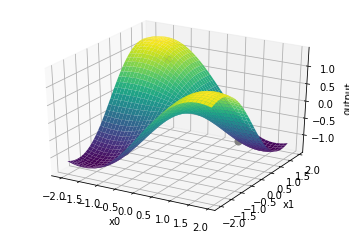

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x0_sampled = np.arange(-2, 2, 0.1)
x1_sampled = np.arange(-2, 2, 0.1)

x0, x1 = np.meshgrid(x0_sampled, x1_sampled)
z = np.zeros_like(x0)

for i, x0i in enumerate(x0_sampled):
    for j, x1i in enumerate(x1_sampled):
        z[i,j] = model.calc_output([x0i, x1i])

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("output")

surf = ax.plot_surface(x0, x1, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.1)

x0s = inputs[:,0]
x1s = inputs[:,1]
zs = outputs
ax.scatter(x0s, x1s, zs, marker = 'o', c = 'gray', s = 50, depthshade = 0)

plt.show()

In [2]:
inputs = np.array([[-2,-2], [-2,-1], [-2,0], [-1,-2], [-1,-1], [-1,0], [0,0], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]])
outputs = np.array([-5, -3, 2, -1, 2, -4, -6, 2, 10, 7, -8,  4, 2])

num_outputs = np.size(outputs[0])
num_inputs = np.size(inputs[0])

num_neurons = np.array([13, num_outputs])

num_layers = len(num_neurons)

model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 5, learning_rate = 0.1, mode = 'sequential')

model.set_centers(inputs)
model.set_weights_interpolation_matrix(inputs, outputs)

model.calc_output(inputs[1])

for i in range (0,len(inputs)):
    print("real output: %f \t predicted output: %f" %(outputs[i], model.calc_output(inputs[i])))
    



real output: -5.000000 	 predicted output: -5.000000
real output: -3.000000 	 predicted output: -3.000000
real output: 2.000000 	 predicted output: 2.000000
real output: -1.000000 	 predicted output: -1.000000
real output: 2.000000 	 predicted output: 2.000000
real output: -4.000000 	 predicted output: -4.000000
real output: -6.000000 	 predicted output: -6.000000
real output: 2.000000 	 predicted output: 2.000000
real output: 10.000000 	 predicted output: 10.000000
real output: 7.000000 	 predicted output: 7.000000
real output: -8.000000 	 predicted output: -8.000000
real output: 4.000000 	 predicted output: 4.000000
real output: 2.000000 	 predicted output: 2.000000


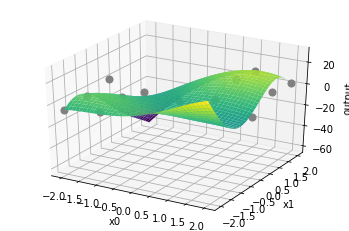

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x0_sampled = np.arange(-2, 2, 0.1)
x1_sampled = np.arange(-2, 2, 0.1)

x0, x1 = np.meshgrid(x0_sampled, x1_sampled)
z = np.zeros_like(x0)

for i, x0i in enumerate(x0_sampled):
    for j, x1i in enumerate(x1_sampled):
        z[i,j] = model.calc_output([x0i, x1i])

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("output")

surf = ax.plot_surface(x0, x1, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.1)

x0s = inputs[:,0]
x1s = inputs[:,1]
zs = outputs
ax.scatter(x0s, x1s, zs, marker = 'o', c = 'gray', s = 50, depthshade = 0)

plt.show()

[220.27179006467523, 170.05966220260254, 147.36906249124223, 126.80449821701711, 109.96920387984059, 96.82821549106211]


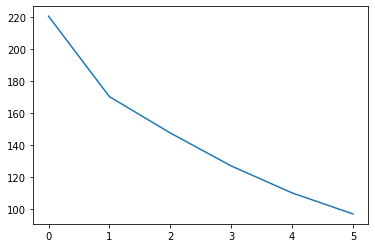

In [3]:
import pandas as pd
from sklearn.cluster import KMeans

wcss = []
for i in range(2,8):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(inputs)
    wcss.append(kmeans.inertia_)

print(wcss)
x = np.arange(0,6,1)
plt.plot(x, wcss)
    
#kmeans.cluster_centers_


In [4]:
from math import sqrt
x1, y1 = 2, wcss[0]
x2, y2 = 8, wcss[len(wcss)-1]

distances = []
for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)
        
print((distances.index(max(distances))+2))

4


In [5]:
kmeans = KMeans(n_clusters = 4, random_state=0).fit(inputs)
kmeans.cluster_centers_

array([[-1.5, -0.5],
       [ 1.5,  1.5],
       [ 1. ,  0. ],
       [-1.5, -2. ]])

In [14]:
kmeans.predict([[30,-3]])

array([1])

In [6]:
centers = kmeans.cluster_centers_
print(centers)



[[-1.5 -0.5]
 [ 1.5  1.5]
 [ 1.   0. ]
 [-1.5 -2. ]]


In [24]:
inputs = np.array([[-2,-2], [-2,-1], [-2,0], [-1,-2], [-1,-1], [-1,0], [0,0], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]])
outputs = np.array([-5, -3, 2, -1, 2, -4, -6, 2, 10, 7, -8,  4, 2])

num_outputs = np.size(outputs[0])
num_inputs = np.size(inputs[0])

num_neurons = np.array([4, num_outputs])

num_layers = len(num_neurons)

model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 1000, learning_rate = 0.1, mode = 'sequential')


model.set_centers(centers)
model.fit(inputs, outputs)
predit = model.predict(inputs)
print(predit)

    



[[-3.40096968]
 [-1.7891217 ]
 [-0.89028666]
 [-4.31748949]
 [-1.97351394]
 [ 0.09619816]
 [-0.09022543]
 [-1.20368795]
 [ 2.74077516]
 [ 4.79864703]
 [-2.9815004 ]
 [ 1.50318446]
 [ 4.06667395]]


In [19]:
## KMEANS COM TODO O DATASET (IRIS)
## CLUSTERIZAÇÃO
## BUSCAR OS CENTROS
## USAR TREINAMENTO PRA FIT COM CENTROS
## PREDITAR O QUE FALTA?
## NÃO SEI O QUE FAZE

In [4]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

data = load_boston()

target = data['target']
data = data['data']

target = target.reshape(len(target), 1)

num_outputs = 1
num_inputs = np.size(data[0])
num_neurons = np.array([4, 1])
num_layers = len(num_neurons)

scaler = MinMaxScaler()
scaler.fit(data)
inputs = scaler.transform(data)
scaler.fit(target)
target = scaler.transform(target)

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(inputs)
    wcss.append(kmeans.inertia_)

from math import sqrt
x1, y1 = 2, wcss[0]
x2, y2 = 8, wcss[len(wcss)-1]

distances = []
for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)
        
print((distances.index(max(distances))+2))

kmeans = KMeans(n_clusters = 4, random_state=0).fit(inputs)
kmeans.cluster_centers_
centers = kmeans.cluster_centers_
print(centers)





4
[[7.89155733e-04 4.48409091e-01 1.51163023e-01 4.54545455e-02
  8.66030677e-02 5.87548991e-01 2.61351933e-01 4.97829471e-01
  1.39130435e-01 2.26578765e-01 4.87911025e-01 9.80133322e-01
  1.30656733e-01]
 [1.43340318e-01 2.22044605e-16 6.46627566e-01 6.06060606e-02
  5.91392318e-01 4.71575305e-01 8.95008270e-01 8.47196744e-02
  1.00000000e+00 9.14122137e-01 8.08510638e-01 7.25627028e-01
  4.65524450e-01]
 [1.40612565e-02 9.71445147e-17 7.67085839e-01 1.52542373e-01
  6.02043663e-01 4.69152802e-01 9.46499328e-01 7.33451692e-02
  1.43699337e-01 4.21626342e-01 5.09556437e-01 8.77618896e-01
  3.98496838e-01]
 [3.30717295e-03 3.98780488e-02 2.47786281e-01 6.34146341e-02
  2.61305832e-01 5.34182326e-01 6.80520459e-01 2.55479626e-01
  1.57582185e-01 2.10603240e-01 6.08510638e-01 9.72187201e-01
  2.59415549e-01]]


In [6]:
#target = target.reshape(1, len(target))

train, test, train_labels, test_labels = train_test_split(inputs, target, test_size = 0.2, random_state=42)

np.random.seed(0)
learning_rate_param = np.arange(0.01, 1, 0.04)

scores = []
for i in learning_rate_param:
    model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 100, learning_rate = i, mode = 'sequential')
    model.set_centers(centers)
    model.fit(train, train_labels)
    predit = model.predict(train)
    mse = mean_squared_error(train_labels, predit)
    scores.append(mse)
    
scores = np.array(scores)




In [7]:
idx = np.argmin(scores)
min_error = min(scores)
learning_rate = 0.01 + idx*0.04

print("Indice de menor erro foi: ", i)
print("Menor erro encontrado no conjunto treinamento: ", min_error)
print("Learning_rate adequado foi: ", learning_rate)

Indice de menor erro foi:  0.97
Menor erro encontrado no conjunto treinamento:  0.031156530206982933
Learning_rate adequado foi:  0.01


In [10]:
model = RBFNeuralNetwork(num_inputs, num_outputs, num_neurons, ["gaussian", "linear"], epochs = 100, learning_rate = 0.01, mode = 'sequential')
model.set_centers(centers)
model.fit(train, train_labels)
predit = model.predict(test)
mse = mean_squared_error(test_labels, predit)
print(mse)

0.025468385403748173
